# SEIRD fixed infectious rate

In [1]:
import os
import datetime

import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
from matplotlib import dates as mdates

from coropy.compartmental_models import SEIRDModel
import plotting

In [2]:
plotting.configure()
b = plotting.default_colors('blue')
o = plotting.default_colors('orange')
g = plotting.default_colors('green')
r = plotting.default_colors('red')

## All inputs

In [3]:
# all data
DATA_DIR = 'data'
FILE_NAME = '1st_wave_data_cro.csv' 
FILE_PATH = os.path.join(os.pardir, DATA_DIR, FILE_NAME)
df = pd.read_csv(FILE_PATH)

# derived data
cum_positives = np.cumsum(df.confirmed_positives.values)
cum_recovered = df.estimate_recovered.values
cum_deceased = np.cumsum(df.confirmed_deceased.values)

# initial conditions
S0 = cum_positives[-1] + cum_deceased[-1]
E0 = 10
I0 = 1
R0 = 0
D0 = 0
IC = [S0, E0, I0, R0, D0]

# dates
start_dt = datetime.datetime(2020, 2, 25)
end_dt = start_dt + datetime.timedelta(cum_positives.size)
dts = mdates.drange(start_dt, end_dt, datetime.timedelta(days=1))

# accuracy
pcr_sens = 0.9
pcr_spec = 0.99

## Model

In [4]:
# transmission rate
beta = 0.5

# system of odes
def SEIRD_ode(t, y, delta, alpha, gamma, mu):
    S, E, I, R, D = y
    N = S + E + I + R + D
    return [
        -beta*S*I/N - delta*S*E, 
        beta*S*I/N - alpha*E + delta*S*E, 
        alpha*E - gamma*I - mu*I, 
        gamma*I,
        mu*I,
    ]

model = SEIRDModel(ode_system=SEIRD_ode)

## Training

In [5]:
params, loss = model.fit(cum_positives, cum_recovered, cum_deceased, IC, guess=[0.1, 0.1, 0.1, 0.1])

INFO:root:L-BFGS-B optimization started: 2020-10-12 08:49:42.336558
INFO:root:Elapsed time: 25.5999s


## Evaluation and visualization

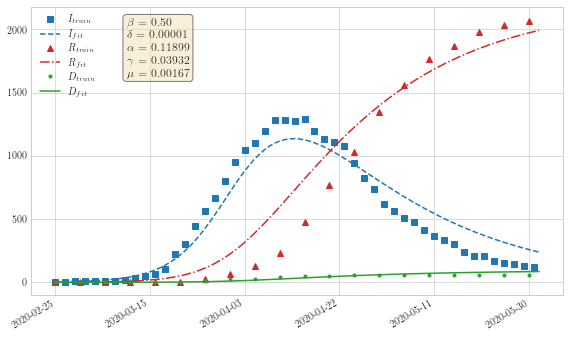

In [6]:
start_dt = datetime.datetime(2020, 2, 25)
end_dt = start_dt + datetime.timedelta(cum_positives.size)
dts = mdates.drange(start_dt, end_dt, datetime.timedelta(days=1))
(S_sim, E_sim, I_sim, R_sim, D_sim) = model.simulate()
fig = plt.figure()
ax = fig.subplots(nrows=1, ncols=1)
ax.plot(dts, cum_positives - cum_recovered - cum_deceased, 's', markevery=2, c=b, label='$I_{train}$')
ax.plot(dts, I_sim, '--', c=b, label='$I_{fit}$')
ax.plot(dts, cum_recovered, '^', markevery=5, c=r, label='$R_{train}$')
ax.plot(dts, R_sim, '-.', c=r, label='$R_{fit}$')
ax.plot(dts, cum_deceased, '.', markevery=5, c=g, label='$D_{train}$')
ax.plot(dts, D_sim, '-', c=g, label='$D_{fit}$')
ax.text(0.18, 0.96,
        '\n'.join((
            r'$\beta$ = %.2f' % (beta, ),
            r'$\delta$ = %.5f' % (params[0], ), 
            r'$\alpha$ = %.5f' % (params[1], ), 
            r'$\gamma$ = %.5f' % (params[2], ),
            r'$\mu$ = %.5f' % (params[3], )
        )),
        transform=ax.transAxes,
        verticalalignment='top', 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.legend()
_ = fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
_ = fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=19))
_ = plt.gcf().autofmt_xdate()
plt.show()
fname = 'SEIRD_fitted_fixed-beta_first-wave_uc-None'
fig.savefig(fname=os.path.join('output', 'figs', fname + '.pdf'), format='pdf', bbox_inches='tight')

## Basic reproduction number

$ R_0 = \frac{\beta}{\delta + \alpha} $

In [7]:
R0 = beta / (params[1] + params[2])
R0

3.1585313030697826

## Loss over epochs

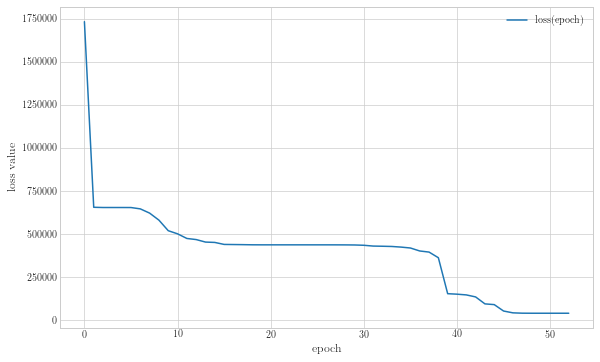

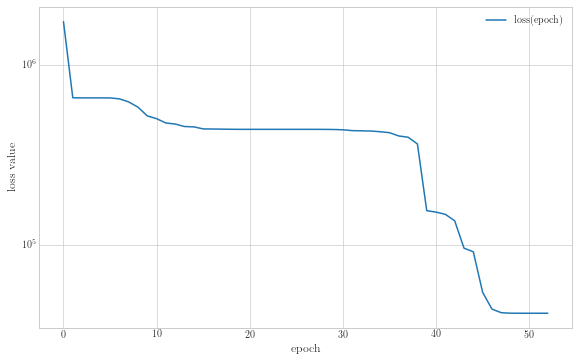

In [8]:
fig = plt.figure()
ax = fig.subplots()
ax.plot(loss, label='loss(epoch)')
ax.set_xlabel('epoch')
ax.set_ylabel('loss value')
ax.legend()
plt.show()
fname = 'SEIRD_fitted_loss'
fig.savefig(fname=os.path.join('output', 'figs', fname + '.pdf'), 
            format='pdf', bbox_inches='tight')

fig = plt.figure()
ax = fig.subplots()
ax.plot(loss, label='loss(epoch)')
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss value')
ax.legend()
plt.show()
fname = 'SEIRD_fitted_loss-log'
fig.savefig(fname=os.path.join('output', 'figs', fname + '.pdf'), format='pdf', bbox_inches='tight')

## Plotting 95% confidence intervals using both the sensitivity and the specificity as qualitative measures of the confirmed positive result

In [9]:
# transmission rate
beta = 0.5

# system of odes
def SEIRD_ode(t, y, delta, alpha, gamma, mu):
    S, E, I, R, D = y
    N = S + E + I + R + D
    return [
        -beta*S*I/N - delta*S*E, 
        beta*S*I/N - alpha*E + delta*S*E, 
        alpha*E - gamma*I - mu*I, 
        gamma*I,
        mu*I,
    ]

model = SEIRDModel(ode_system=SEIRD_ode, calc_ci=True, pcr_sens=pcr_sens, pcr_spec=pcr_spec, daily_tests=df.total_tests.values)

params, loss = model.fit(cum_positives, cum_recovered, cum_deceased, IC, guess=[0.1, 0.1, 0.1, 0.1])

INFO:root:L-BFGS-B optimization started: 2020-10-12 08:50:11.353666
INFO:root:Elapsed time: 25.4679s


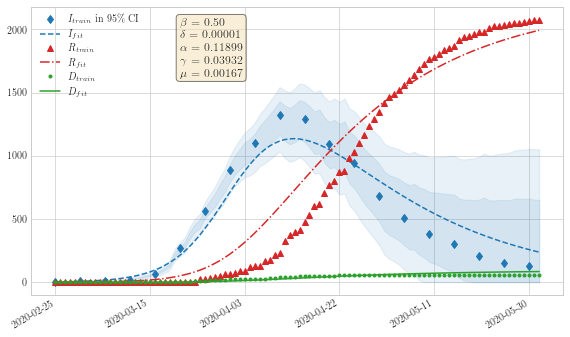

In [10]:
start_dt = datetime.datetime(2020, 2, 25)
end_dt = start_dt + datetime.timedelta(cum_positives.size)
dts = mdates.drange(start_dt, end_dt, datetime.timedelta(days=1))
(S_sim, E_sim, I_sim, R_sim, D_sim) = model.simulate()
fig = plt.figure()
ax = fig.subplots(nrows=1, ncols=1)
ax.plot(dts, cum_positives - cum_recovered - cum_deceased, 'd', markevery=5, c=b, label='$I_{train}$ in $95\%$ CI')
ax.plot(dts, I_sim[2], '--', c=b, label='$I_{fit}$')
ax.fill_between(dts, I_sim[0], I_sim[4], color=b, alpha=0.1)
ax.fill_between(dts, I_sim[1], I_sim[3], color=b, alpha=0.1)
ax.plot(dts, cum_recovered, '^', c=r, label='$R_{train}$')
ax.plot(dts, R_sim, '-.', c=r, label='$R_{fit}$')
ax.plot(dts, cum_deceased, '.', c=g, label='$D_{train}$')
ax.plot(dts, D_sim, '-', c=g, label='$D_{fit}$')
ax.text(0.28, 0.96,
        '\n'.join((
            r'$\beta$ = %.2f' % (beta, ),
            r'$\delta$ = %.5f' % (params[0], ), 
            r'$\alpha$ = %.5f' % (params[1], ), 
            r'$\gamma$ = %.5f' % (params[2], ),
            r'$\mu$ = %.5f' % (params[3], )
        )),
        transform=ax.transAxes,
        verticalalignment='top', 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.legend()
_ = fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
_ = fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=19))
_ = plt.gcf().autofmt_xdate()
plt.show()
fname = f'SEIRD_fitted_fixed-beta_first-wave_uc-{int(pcr_sens*100)}sens-{int(pcr_spec*100)}spec-95ci'
fig.savefig(fname=os.path.join('output', 'figs', fname + '.pdf'), format='pdf', bbox_inches='tight')